# Seq2Seq MXNet Addition Example

This notebook walks through a neural network implementation to perform basic math operators like addition and multiplication. The objective is to show you can convert from a given set of input sequences to an output sequence.

Its inspired by serveral blogs, but mainly from this paper - "Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf


In [1]:
import math
import numpy as np
import mxnet as mx
import mxnet.ndarray as nd

import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(10)

n_samples = 1000 # Training Set
n_numbers = 3 # how many numbers do we want to operate on

largest = 10 #largest INT 

# Character set 
character_set = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '*', ' ']
data_dim = len(character_set)  # size of our vocab; also one hot encoding size

input_seq_length = 8 # max_digit_len + n_operators = n_numbers*2 + 2
output_seq_length = n_numbers + 1 #MAX Output Length
batch_size = 32
epochs = 100

print input_seq_length, output_seq_length

8 4


Lets define a helper function to generate our training data, in this case we'll generate sum pairs

(ex: 5+4+9 = 18, 1+4+2 = 7, 3*2*5=30 etc)

We will also encode these with our character_set or character set defined above. for example character_set[1] is "1", character_set[2] is 2 and so on for all the numbers, and we'll define the operators "+" & "*" as indices after that. Space " " is used for padding. We'll later convert this to one-hot encoding 
[<LINK>?]

In [2]:
def get_sum_pairs(n_examples):
    inputs, labels = list(), list()
    char_to_int = dict((c, i) for i, c in enumerate(character_set)) # lookup table

    for i in range(n_examples):
        lhs = [random.randint(1, largest) for _ in range(n_numbers)]
        op = random.choice(['+', '*']) 
        if op == '+':
            rhs = sum(lhs)
        elif op == '*':
            rhs = 1
            for l in lhs:
                rhs *= l

        #LHS
        lhs = [str(l) for l in lhs]
        strng = "*".join(lhs) if op == "*" else "+".join(lhs)  # + or * only
        padded_strng = "%*s"  % (input_seq_length, strng)
        inp_encoded = [char_to_int[char] for char in padded_strng]
        
        #RHS
        padded_strng = "%*s"  % (output_seq_length, str(rhs))
        out_encoded = [char_to_int[char] for char in padded_strng]
        inputs.append(inp_encoded)
        labels.append(out_encoded)
        
    print len(inputs), len(labels)
    return np.array(inputs), np.array(labels)
 

dataX, dataY = get_sum_pairs(n_samples)

print dataX.shape, dataY.shape

1000 1000
(1000, 8) (1000, 4)


In [3]:
## Lets define the Iterator
train_iter = mx.io.NDArrayIter(data=dataX, label=dataY,
                                 data_name="data", label_name="target",
                                 batch_size=batch_size,
                                 shuffle=True)

print train_iter.provide_data, train_iter.provide_label

[DataDesc[data,(32, 8L),<type 'numpy.float32'>,NCHW]] [DataDesc[target,(32, 4L),<type 'numpy.float32'>,NCHW]]


### Lets implement a encoder/decoder with LSTM Model

Note that we'll use mx.sym.one_hot symbol to convert our input in to one-hot encoding before it gets fed in to the encoder layer of the LSTM

To get a primer on LSTMs and RNNs you can refer to these blogs

[LSTM basics](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) 

[encoder/decoder](http://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/) 

[timeseries modeling](https://github.com/sunilmallya/mxnet-notebooks/blob/master/python/tutorials/aws_spot_price_predict_lstm.ipynb)

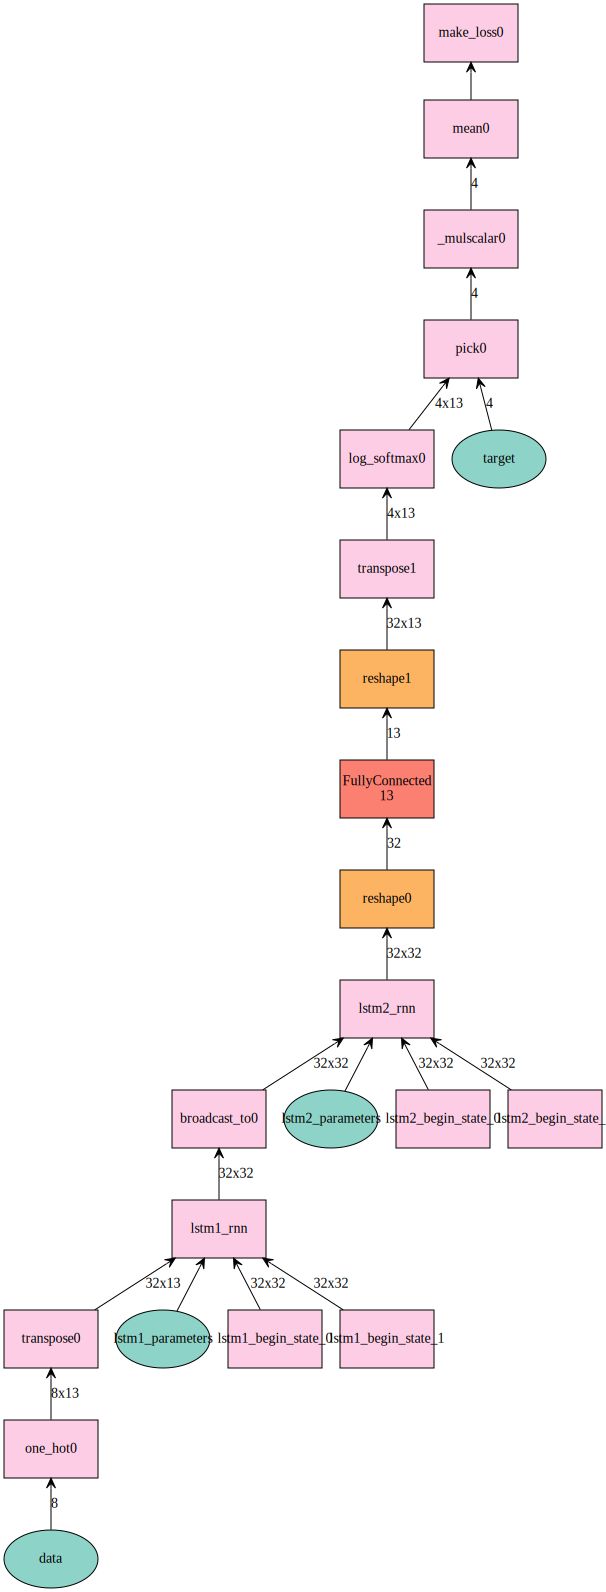

In [4]:
data = mx.sym.var('data')  # Shape: (N, T)
target = mx.sym.var('target')  # Shape: (N, T)

# 2 Layer LSTM 
# get_next_state = return the states that can be used as starting states next time
lstm1 = mx.rnn.FusedRNNCell(num_hidden=32, prefix="lstm1_", get_next_state=True)
lstm2 = mx.rnn.FusedRNNCell(num_hidden=32, prefix="lstm2_", get_next_state=False)

# In the layout, 'N' represents batch size, 'T' represents sequence length,
# and 'C' represents the number of dimensions in hidden states.
  
# one hot encode 
data_one_hot = mx.sym.one_hot(data, depth=data_dim) # Shape: (N, T, C)
data_one_hot = mx.sym.transpose(data_one_hot, axes=(1, 0, 2)) # Shape: (T, N, C)

# Note that when unrolling, if 'merge_outputs'== True, the 'outputs' is merged into a single symbol
# encoder  (with repeat vector)
_, encode_state = lstm1.unroll(length=input_seq_length, inputs=data_one_hot, layout="TNC")
encode_state_h = mx.sym.broadcast_to(encode_state[0], shape=(output_seq_length, 0, 0)) #Shape: (T,N,C); use ouput seq shape

# decoder
decode_out, _ = lstm2.unroll(length=output_seq_length, inputs=encode_state_h, layout="TNC")
decode_out = mx.sym.reshape(decode_out, shape=(-1, batch_size))

# logits out
logits = mx.sym.FullyConnected(decode_out, num_hidden=data_dim, name="logits")
logits = mx.sym.reshape(logits, shape=(output_seq_length, -1, data_dim))
logits = mx.sym.transpose(logits, axes=(1, 0, 2))

# Lets define a loss function: Convert Logits to softmax probabilities
loss = mx.sym.mean(-mx.sym.pick(mx.sym.log_softmax(logits), target, axis=-1))
loss = mx.sym.make_loss(loss)

# visualize
shape = {"data" : (batch_size, dataX[0].shape[0])}
mx.viz.plot_network(loss, shape=shape)

Build the module

In [5]:
net = mx.mod.Module(symbol=loss,
                    data_names=['data'],
                    label_names=['target'],
                    context=mx.gpu())

net.bind(data_shapes=train_iter.provide_data,
            label_shapes=train_iter.provide_label)


net.init_params(initializer=mx.init.Xavier())
net.init_optimizer(optimizer="adam",
                   optimizer_params={'learning_rate': 1E-3,
                                     'rescale_grad': 1.0},
                   kvstore=None)

### Training 

In [6]:
epochs = 150
total_batches =  len(dataX) // batch_size
for epoch in range(epochs):
    avg_loss = 0
    train_iter.reset()
    for i, data_batch in enumerate(train_iter): 
        net.forward_backward(data_batch=data_batch)
        loss = net.get_outputs()[0].asscalar()
        avg_loss += loss /total_batches
        net.update()
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_loss))

('Epoch:', '0001', 'cost =', '2.488914397')
('Epoch:', '0002', 'cost =', '1.994357786')
('Epoch:', '0003', 'cost =', '1.500532869')
('Epoch:', '0004', 'cost =', '1.324073261')
('Epoch:', '0005', 'cost =', '1.214142692')
('Epoch:', '0006', 'cost =', '1.138869951')
('Epoch:', '0007', 'cost =', '1.090947459')
('Epoch:', '0008', 'cost =', '1.059179443')
('Epoch:', '0009', 'cost =', '1.035796508')
('Epoch:', '0010', 'cost =', '1.016810117')
('Epoch:', '0011', 'cost =', '1.000326949')
('Epoch:', '0012', 'cost =', '0.985143715')
('Epoch:', '0013', 'cost =', '0.970109126')
('Epoch:', '0014', 'cost =', '0.954816386')
('Epoch:', '0015', 'cost =', '0.940555248')
('Epoch:', '0016', 'cost =', '0.927457961')
('Epoch:', '0017', 'cost =', '0.915424118')
('Epoch:', '0018', 'cost =', '0.904117994')
('Epoch:', '0019', 'cost =', '0.893924356')
('Epoch:', '0020', 'cost =', '0.884643414')
('Epoch:', '0021', 'cost =', '0.875751190')
('Epoch:', '0022', 'cost =', '0.866442223')
('Epoch:', '0023', 'cost =', '0.

#### Testing

Lets define a test network

In [7]:
# test module
test_net = mx.mod.Module(symbol=logits,
                         data_names=['data'],
                         label_names=None,
                         context=mx.gpu()) # FusedRNNCell works only with GPU

# data descriptor
data_desc = train_iter.provide_data[0]

# set shared_module = model used for training so as to share same parameters and memory
test_net.bind(data_shapes=[data_desc],
              label_shapes=None,
              for_training=False,
              grad_req='null',
              shared_module=net)

n_test = 100
testX, testY = get_sum_pairs(n_test)

testX = np.array(testX, dtype=np.int)

test_net.reshape(data_shapes=[mx.io.DataDesc('data', (1, input_seq_length))])
predictions = test_net.predict(mx.io.NDArrayIter(testX, batch_size=1)).asnumpy()

print "expression", "predicted", "actual"

correct = 0
for i, prediction in enumerate(predictions):
    x_str = [character_set[j] for j in testX[i]]
    index = np.argmax(prediction, axis=1)
    result = [character_set[j] for j in index]
    label = [character_set[j] for j in testY[i]]
    #print result, label
    if result == label:
        correct +=1
    print "".join(x_str), "".join(result), "    ", "".join(label)
    
print correct, correct/(n_test*1.0)

100 100
expression predicted actual
   7+4+3   14        14
   6+9+3   18        18
   6*4*3   92        72
   6*9*2  188       108
  4*10*8  340       320
   8*4*1   36        32
   4+8+2   15        14
  10*4*3  160       120
   7*5*1   35        35
   1*9*1    9         9
   6*2*5   60        60
   4*9*4  146       144
   1+8+9   18        18
   9+1+2   12        12
   6*9*2  188       108
   9*1*2   12        18
  10+6+3   10        19
   4+8+1   13        13
  10*3*8  260       240
   3*6*6  198       108
   3*4*1   12        12
  10+6+8   24        24
   3+5+2   10        10
   3*6*7  128       126
  2+10+8   20        20
 8*10*10  800       800
   9+1+8   18        18
   6+5+9   20        20
   6*3*2   32        36
  6+10+4   20        20
   3+9+6   18        18
   4*2*5   40        40
   2*3*5   30        30
   8*8*5  240       320
  10*1*2   20        20
  5+10+3   18        18
  10+8+4   22        22
   1*6*6   36        36
   4+2+2    7         8
   9*3*7  117       189
   5

## Things to try

1. Increase training samples
2. More epochs
3. Try augmenting the input sequence by reversing it. multiplication & addition are commutative
4. More operators, may be try a generic caluclator

### Additional Resources

Content was inspired by some of the work below

https://github.com/hunkim/DeepLearningZeroToAll/blob/master/mxnet/mxlab-12-5-seq2seq.py   

http://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/